In [ ]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-addons==0.17.0
#above instead of tensorflow-addons==0.17.0 we can even use tensorflow-addons==0.20.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 35.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: g

In [ ]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes=10
input_shape=(32,32,3)
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001#1e-4
batch_size = 256
num_epochs = 40  #40
image_size = 72 #resize the input image to this size
patch_size = 6 #size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
num_heads = 4
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim
] #size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #size of the dense layers of the final classifiers

In [ ]:
data_augumentation = keras.Sequential(
    [
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_augmentation"
)
data_augumentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x,hidden_units,dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units,activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size = patch_size


    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1,self.patch_size,self.patch_size,1],
            strides = [1,self.patch_size,self.patch_size,1],
            rates = [1,1,1,1],
            padding = "VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,shape=(batch_size, -1, patch_dims))
        return patches



Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108



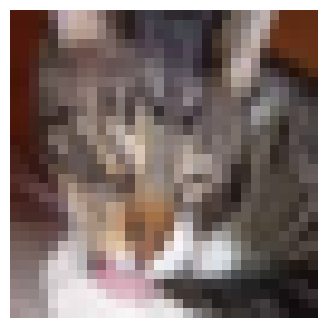

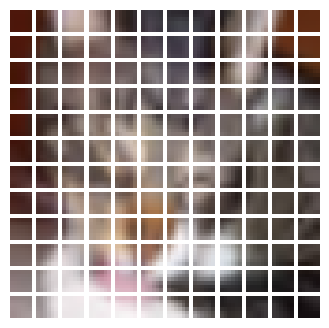

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = tf.image.resize(
    tf.convert_to_tensor([image]),
    size = (image_size,image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}\n")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch, (patch_size,patch_size,3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

  # Adjust these values as needed
plt.show()


170498071/170498071 [==============================] - 4s 0us/step


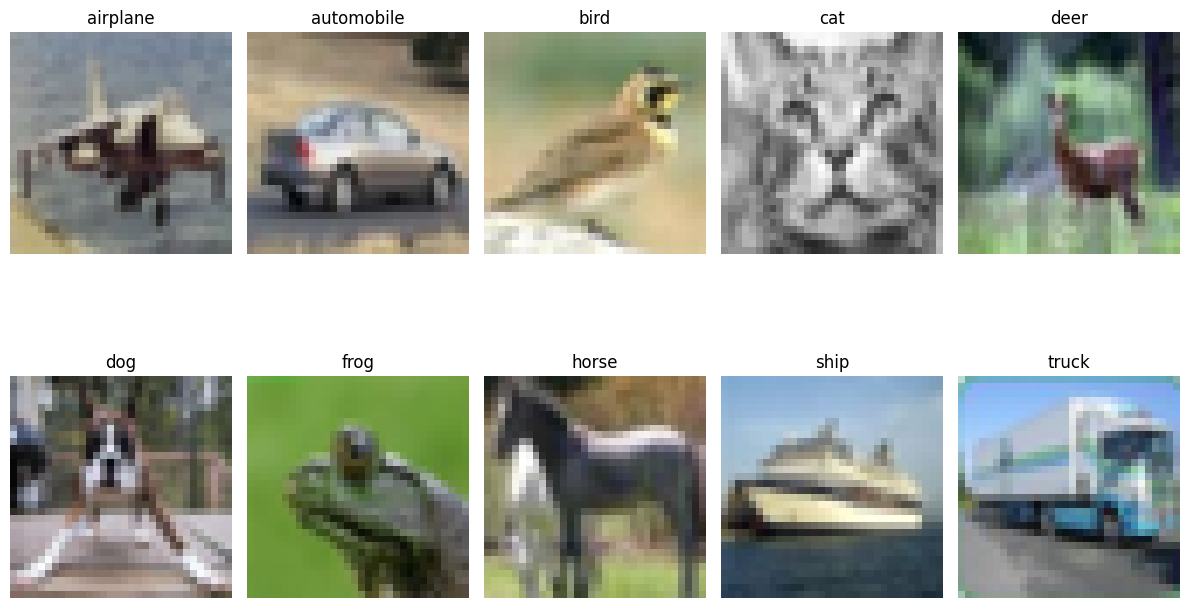

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

images_per_class = {}

for class_id, class_name in enumerate(class_names):
    class_indices = np.where(y_train == class_id)[0]

    sample_image = x_train[np.random.choice(class_indices)]

    images_per_class[class_name] = sample_image

plt.figure(figsize=(12, 8))
for i, (class_name, image) in enumerate(images_per_class.items()):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self,num_patches,projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
    def call(self,patches):
        positions = tf.range(start=0,limit=self.num_patches,delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape=input_shape)
  #Augument data
  augmented = data_augumentation(inputs)
  patches = Patches(patch_size)(augmented)
  #encode patches
  encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)


  #create multiple layers of the transformer block
  for _ in range(transformer_layers):
    # layer normalization
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #create multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads = num_heads,
        key_dim = projection_dim,
        dropout = 0.1
    )(x1,x1)
    #add skip connection1
    x2 = layers.Add()([attention_output,encoded_patches])
    #layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    #feed forward block mlp
    x3 = mlp(x3,hidden_units=transformer_units,dropout_rate=0.1)
    #add skip connection2
    encoded_patches = layers.Add()([x3,x2])

    #create a [batch_size,projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #Add mlp
    features = mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
    #Classify outputs
    logits = layers.Dense(num_classes)(features)
    #create model
    model = keras.Model(inputs=inputs,outputs=logits)
    return model



In [ ]:
def run_experiment(model):

  optimizer = tfa.optimizers.AdamW(
      learning_rate = learning_rate,
      weight_decay = weight_decay
  )

  model.compile(
      optimizer = optimizer,
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics = [
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics.SparseTopKCategoricalAccuracy(5,name="top_5_accuracy"),
      ],
  )
  checkpoint_filepath = "./tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
       checkpoint_filepath,
       monitor = "val_accuracy",
       save_best_only = True,
       save_weights_only = True,
  )

  history = model.fit(
      x = x_train,
      y = y_train,
      batch_size = batch_size,
      epochs = num_epochs,
      validation_split = 0.1,
      callbacks = [checkpoint_callback],
  )
  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy= model.evaluate(x_test,y_test)
  print(f"Test accuracy: {round(accuracy*100,2)}%")
  print(f"Test top-5 accuracy: {round(top_5_accuracy*100,2)}%")

  return history


In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - 14s 5s/step - loss: 5.9867 - accuracy: 0.1067 - top_5_accuracy: 0.5444 - val_loss: 4.0555 - val_accuracy: 0.2200 - val_top_5_accuracy: 0.7200
Epoch 2/40
2/2 [==============================] - 7s 3s/step - loss: 5.7216 - accuracy: 0.2444 - top_5_accuracy: 0.7133 - val_loss: 3.2024 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.8000
Epoch 3/40
2/2 [==============================] - 11s 5s/step - loss: 4.1878 - accuracy: 0.2333 - top_5_accuracy: 0.7622 - val_loss: 3.1905 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.7600
Epoch 4/40
2/2 [==============================] - 9s 6s/step - loss: 3.5109 - accuracy: 0.2733 - top_5_accuracy: 0.7978 - val_loss: 2.4080 - val_accuracy: 0.2800 - val_top_5_accuracy: 0.8200
Epoch 5/40
2/2 [==============================] - 7s 3s/step - loss: 2.9106 - accuracy: 0.3089 - top_5_accuracy: 0.7844 - val_loss: 2.2043 - val_accuracy: 0.1800 - val_top_5_accuracy: 0.7600
Epoch 6/40
2/2 [===========================

In [ ]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
def img_predict(images,model):
  if len(images.shape) == 3:
    out = model.predict(images.reshape(-1, *images.shape))
  else:
    out = model.predict(images)
  prediction = np.argmax(out, axis=1)
  img_prediction = [class_names[i] for i in prediction]
  return img_prediction

['ship']


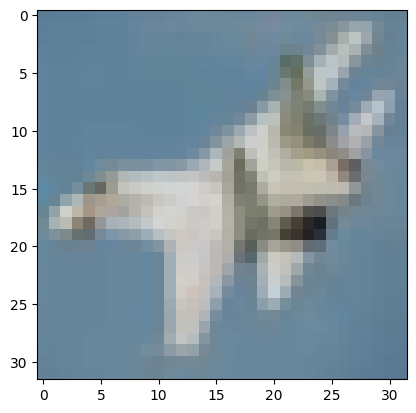

In [ ]:
index = 10
plt.imshow(x_test[index])
prediction = img_predict(x_test[index],vit_classifier)
print(prediction)